# Multi-Stage Filtering Framework for Retinal Fundus Image Enhancement

**Objective:** Enhance retinal fundus images using a classical multi-stage filtering pipeline (LAB Color Space).

**Methodology:**
1. **CLAHE** on Luminance Channel (Contrast)
2. **Bilateral Filtering** on Luminance Channel (Denoising)
3. **Unsharp Masking** on Luminance Channel (Sharpening)

**Metrics:** PSNR, SSIM, Entropy, CII.

In [10]:
# Install dependencies (if not present)
import sys
!{sys.executable} -m pip install opencv-python-headless matplotlib numpy

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- UTILITIES ---

def calculate_psnr(original, processed):
    return cv2.PSNR(original, processed)

def calculate_ssim(img1, img2):
    """
    Custom implementation of Structural Similarity Index (SSIM) using NumPy/OpenCV.
    """
    # Convert to grayscale
    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]

    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean()

def calculate_entropy(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def calculate_cii(original, enhanced):
    if len(original.shape) == 3:
        orig = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    else:
        orig = original
    if len(enhanced.shape) == 3:
        enh = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    else:
        enh = enhanced
    c_orig = np.std(orig.astype(float))
    c_enh = np.std(enh.astype(float))
    if c_orig == 0: return 0
    return c_enh / c_orig

def generate_synthetic_fundus(width=512, height=512):
    img = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        intensity = 255 - int(50 * (y / height))
        img[y, :, 2] = intensity
        img[y, :, 1] = int(intensity * 0.6)
        img[y, :, 0] = int(intensity * 0.1)
    num_vessels = 15
    for _ in range(num_vessels):
        pt1 = (np.random.randint(0, width), np.random.randint(0, height))
        pt2 = (np.random.randint(0, width), np.random.randint(0, height))
        thickness = np.random.randint(1, 4)
        cv2.line(img, pt1, pt2, (10, 40, 100), thickness)
    img = cv2.GaussianBlur(img, (21, 21), 0)
    noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    return noisy_img

In [ ]:
# --- PIPELINE ---

class ImageEnhancementPipeline:
    def __init__(self):
        """
        Initializes the optimized classical pipeline (LAB Color Space).
        """
        self.clahe_clip = 2.0
        self.clahe_grid = (8, 8)
        self.bilateral_d = 5
        self.bilateral_sigma_color = 50
        self.bilateral_sigma_space = 50
        self.sharpen_amount = 0.8

    def run(self, image):
        # 1. Convert to LAB
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # 2. CLAHE on L-Channel
        clahe = cv2.createCLAHE(clipLimit=self.clahe_clip, tileGridSize=self.clahe_grid)
        l_enhanced = clahe.apply(l)

        # 3. Bilateral Filter on L-Channel
        l_denoised = cv2.bilateralFilter(l_enhanced,
                                         self.bilateral_d,
                                         self.bilateral_sigma_color,
                                         self.bilateral_sigma_space)

        # 4. Sharpening
        gaussian = cv2.GaussianBlur(l_denoised, (0, 0), 3)
        l_sharpened = cv2.addWeighted(l_denoised, 1.0 + self.sharpen_amount, gaussian, -self.sharpen_amount, 0)

        # 5. Merge and return
        merged_lab = cv2.merge((l_sharpened, a, b))
        return cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)

### Choose Input Image

This cell handles input for both **Google Colab** (via upload) and **Local Execution** (via path).

- **Local Users**: Change the `LOCAL_IMAGE_PATH` variable to your image file.
- **Colab Users**: Leave it as None or empty to trigger the upload button.

In [12]:
input_image = None

# === USER CONFIGURATION ===
LOCAL_IMAGE_PATH = "data/test.png"  # <--- SET THIS if running locally (e.g., "image.jpg")
# ==========================

try:
    # Try to import google.colab to check if we are in Colab environment
    from google.colab import files
    print("Detected Google Colab environment.")

    uploaded = files.upload()
    if len(uploaded) > 0:
        filename = list(uploaded.keys())[0]
        # Convert to standard format
        file_bytes = np.frombuffer(uploaded[filename], dtype=np.uint8)
        input_image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
        print(f"Loaded uploaded image: {filename}")
    else:
        print("No file uploaded.")

except ImportError:
    # Fallback for Local Environment
    print("Detected Local Environment (or no google.colab).")

    if LOCAL_IMAGE_PATH and os.path.exists(LOCAL_IMAGE_PATH):
        print(f"Loading local image from: {LOCAL_IMAGE_PATH}")
        input_image = cv2.imread(LOCAL_IMAGE_PATH, cv2.IMREAD_COLOR)
        if input_image is None:
            print("Error: Failed to load valid image from path.")
    else:
        print(f"File not found at: {LOCAL_IMAGE_PATH}")
        print("Using generated synthetic image instead.")

if input_image is None:
    print("Generating synthetic retinal image...")
    input_image = generate_synthetic_fundus()

Detected Google Colab environment.


Saving test.png to test.png
Loaded uploaded image: test.png


Running enhancement...
PSNR: 24.22 dB
SSIM: 0.7299
CII:  1.0730


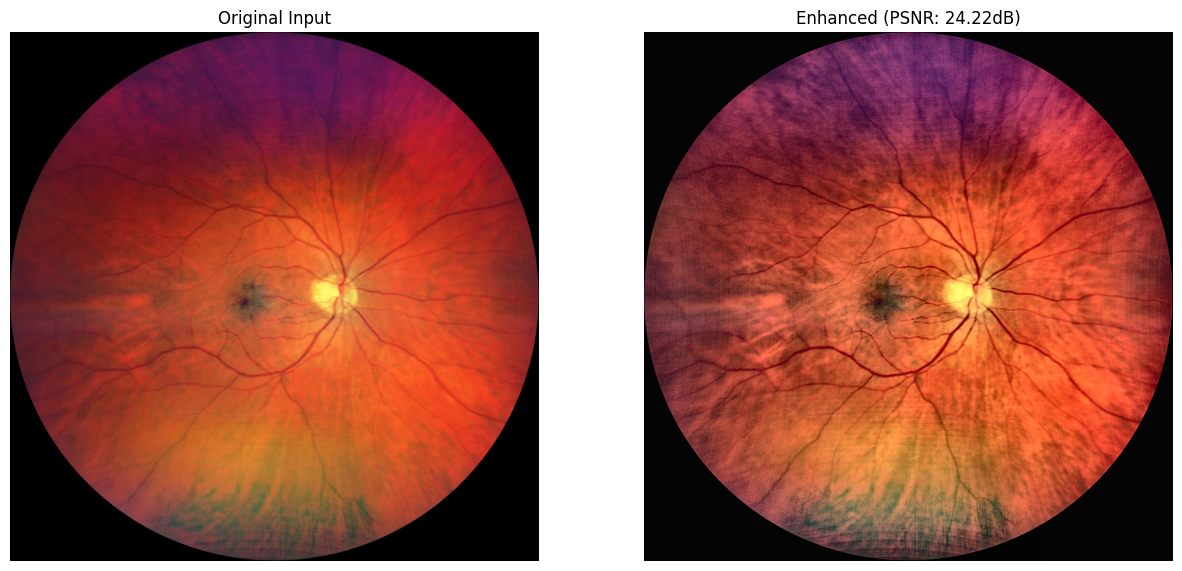

In [13]:
# --- EXECUTION ---

# Run Pipeline
print("Running enhancement...")
pipeline = ImageEnhancementPipeline()
enhanced_image = pipeline.run(input_image)

# Evaluate
psnr = calculate_psnr(input_image, enhanced_image)
ssim_val = calculate_ssim(input_image, enhanced_image)
cii = calculate_cii(input_image, enhanced_image)

print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")
print(f"CII:  {cii:.4f}")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Input")
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
ax[1].set_title(f"Enhanced (PSNR: {psnr:.2f}dB)")
ax[1].axis('off')

plt.show()